# Compute lake area

### 0. Import libraries and load data

In [63]:
import os
import cv2
import sys
import copy
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from matplotlib.colors import ListedColormap
from sklearn.metrics import f1_score, cohen_kappa_score
from scipy.ndimage import binary_dilation, binary_closing


plt.style.use('seaborn-v0_8')

TRAIN_LAKES = ["abert", "mono", "nakuru"]
TEST_LAKES = ["walker"]

FIRST_DATE = "1984-03"
LAST_DATE = "2012-04"
DILATION_SIZE = 3
SPATIAL_RESOLUTION = 30
MISSING_DATA_THRESHOLD = 0.5
DATA_PATH = "../data/{lake_name}/"
BLUE_BAND = 1
GREEN_BAND = 2
RED_BAND = 3
WATER_INDEX_BAND = 20
GROUND_TRUTH_BAND = 21

%matplotlib inline

In [64]:
def load_lakes(lake_names):
    # create a sorted distrionary by date that stores for each date of the specified lakes all the bands of interest
    names_dates = []
    bands = []

    for lake_name in lake_names:
        # read data for current lake
        dates = [date for date in os.listdir(DATA_PATH.format(lake_name=lake_name))]
        maps = [rasterio.open(DATA_PATH.format(lake_name=lake_name) + date) for date in dates]

        names_dates_current_lake = [lake_name + "_"+ date[:-4] for date in dates]
        # select bands of interest
        bands_current_lake = [
            [
                map.read(band_index)
                for band_index in [
                    WATER_INDEX_BAND,
                    GROUND_TRUTH_BAND,
                    RED_BAND,
                    GREEN_BAND,
                    BLUE_BAND,
                ]
            ]
            for map in maps
        ]

        # store the data for the current lake
        names_dates.extend(names_dates_current_lake)
        bands.extend(bands_current_lake)

    # build the dictioanry and return it
    data = {k: v for k, v in sorted(dict(zip(names_dates, bands)).items(), key=lambda x: x[0])}

    return data


In [65]:
train_data = load_lakes(TRAIN_LAKES)
test_data = load_lakes(TEST_LAKES)

### 2. Train lake detector

In [24]:
def get_min_max_values(data):
    # get the global min and max values of the water index across the dataset
    min_value = sys.maxsize
    max_value = -sys.maxsize

    for bands in data.values():
        min_value = min(min_value, bands[0].flatten().min())
        max_value = max(max_value, bands[0].flatten().max())

    return min_value, max_value

In [25]:
def preprocess_ground_truth(ground_truth):
    ground_truth_copy = copy.deepcopy(ground_truth) 
    # replace no data 0 with 3
    ground_truth_copy[ground_truth_copy == 0] = 3
    # replace water detection 2 with 0 for water
    ground_truth_copy[ground_truth_copy == 2] = 0
    # represent water with 1 and no water with 0
    ground_truth_copy = 1 - ground_truth_copy

    return ground_truth_copy

In [49]:
def compute_scores_per_fold(data, data_indices, threshold):
    # initialize values
    f1 = 0
    kappa = 0
    number_of_images = 0

    # iterate over data that have an index from the passed list
    for index in data_indices:
        water_detection = (list(data.values())[index][0] > threshold).flatten()
        ground_truth = list(data.values())[index][1]

        # consider the ground truth only if it has less than 50% missing data
        if sum(ground_truth.flatten() == 0) / len(ground_truth.flatten()) <= MISSING_DATA_THRESHOLD:
            preprocessed_ground_truth = preprocess_ground_truth(ground_truth).flatten()

            # get the indices of pixels with data 
            empty_indices = np.where(preprocessed_ground_truth == -2)[0]

            # if the ground truth contains any pixels with info compute the f1 score
            if len(empty_indices) > 0:
                number_of_images += 1
                f1 += f1_score(np.delete(preprocessed_ground_truth, empty_indices), np.delete(water_detection, empty_indices), average='weighted')
                kappa += cohen_kappa_score(np.delete(preprocessed_ground_truth, empty_indices), np.delete(water_detection, empty_indices))

    return f1, kappa, number_of_images

In [50]:
def compute_scores_per_dataset(data, data_indices, threshold):
    f1_score_cum = 0
    kappa_score_cum = 0
    number_of_images_cum = 0
    
    # compute metrics for each fold
    for data_indices_subset in data_indices:
        f1, kappa, number_of_images = compute_scores_per_fold(data, data_indices_subset, threshold)
        f1_score_cum += f1
        kappa_score_cum += kappa
        number_of_images_cum += number_of_images

    # compute the average metric for each threshold
    return f1_score_cum / number_of_images_cum, kappa_score_cum / number_of_images_cum


In [51]:
min_value, max_value = get_min_max_values(train_data)
# define the space for thresholds
thresholds =  np.linspace(min_value, max_value, 10)

# split data indices into folds, so that in each subset are indices of 2 lakes
data_indices = [[index for index, name_date in enumerate(list(train_data.keys())) if lake_name not in name_date] for lake_name in TRAIN_LAKES]

f1_scores = []
kappa_scores = []

# go over each threshold
for threshold in tqdm(thresholds):
    # compute the average metric for the current threshold
    avg_f1, avg_kappa = compute_scores_per_dataset(train_data, data_indices, threshold)

    f1_scores.append(avg_f1)
    kappa_scores.append(avg_kappa)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:08<00:00,  6.81s/it]


In [52]:
threshold_scores = pd.DataFrame({"threshold": thresholds, "f1_score": f1_scores, "kappa_score": kappa_scores}).sort_values("f1_score", ascending=False)
threshold_scores

,threshold,f1_score,kappa_score
8,0.129782,0.923996,0.804783
7,-0.653812,0.785286,0.525908
9,0.913376,0.628310,0.000000
6,-1.437406,0.188897,0.033251
5,-2.221000,0.123413,0.005063
4,-3.004595,0.112253,0.000190
1,-5.355377,0.111821,0.000003
2,-4.571783,0.111821,0.000003
3,-3.788189,0.111821,0.000003
0,-6.138971,0.111816,0.000001


In [ ]:
def predict(data, threshold):
    # create a list that stores the detections obtained with the best threshold
    detections = []

    for date in data.keys():
        detections.append(data[date][0] > threshold)

    return detections

In [140]:
best_threshold = threshold_scores["threshold"].iloc[0]
train_detections = predict(train_data, best_threshold)

### 3. Test lake detector

In [141]:
test_detections = predict(test_data, best_threshold)

# compute the test metrics with the current threshold
avg_f1, avg_kappa = compute_scores_per_dataset(test_data, [list(range(len(test_data)))], best_threshold)
print(f"Test F1: {avg_f1}\nTest kappa: {avg_kappa}")

Test F1: 0.9956829623534279
Test kappa: 0.9911412070637154


### 4. Analyze lake evolution

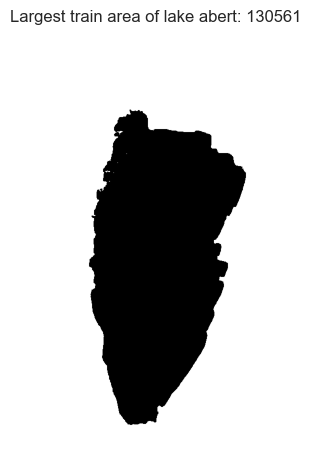

100%|██████████| 3/3 [00:00<00:00,  6.39it/s]


In [157]:
lake_name = "abert"

indices = [index for index, date in enumerate(list(train_data.keys())) if lake_name in date]
lake_detections = np.array(train_detections)[indices]

largest_train_area_mask_overall, largest_train_area_overall, train_dilated_detections = get_largest_lake_mask(lake_detections)

# display the mask of the lake when it has the largest area
plt.imshow(largest_train_area_mask_overall)
plt.title(f"Largest train area of lake {lake_name}: {largest_train_area_overall}")
plt.axis("off")

plt.show()

isolated_detections, filled_isolated_detections = remove_adjacent_water_bodies(lake_detections, largest_train_area_mask_overall)

area_by_month = estimate_area_by_month(filled_isolated_detections, lake_name, list(train_data.keys()))

plot_lake_area_by_month(train_detections, train_data, lake_name)

In [ ]:
def display_image(index):

    try: 
        if dilated_detections is not None:
            fig, ax = plt.subplots(1, 6)
            fig.set_size_inches(24, 6)
    except NameError:
        fig, ax = plt.subplots(1, 3)
        fig.set_size_inches(14, 6)

    date = list(data.keys())[index]

    ax[0].imshow(data[date][0])
    ax[0].set_title("Water index")
    ax[0].axis("off")

    ax[1].imshow(data[date][1])
    ax[1].set_title("Ground truth")
    ax[1].axis("off")

    ax[2].imshow(best_detections[index])
    ax[2].set_title("Detection")
    ax[2].axis("off")

    try:
        if dilated_detections is not None:
            ax[3].imshow(dilated_detections[index])
            ax[3].set_title("Dilated detection")
            ax[3].axis("off")

            ax[4].imshow(isolated_detections[index])
            ax[4].set_title("Isolated detection")
            ax[4].axis("off")

            ax[5].imshow(filled_isolated_detections[index])
            ax[5].set_title("Filled isolated detection")
            ax[5].axis("off")
    except NameError:
        pass

    fig.suptitle(f"Year-month: {date}")

    plt.show()
    plt.close()

interact(display_image, index=widgets.IntSlider(min=0, max=len(data) - 1, step=1, value=0))


In [158]:
interact(display_image, index=widgets.IntSlider(min=0, max=len(data) - 1, step=1, value=0))

NameError: name 'display_image' is not defined

In [155]:
def get_largest_lake_mask(lake_detections):
    # find the mask of the lake when it has the largest area
    largest_area_overall = -sys.maxsize
    largest_area_mask_overall = None
    dilated_detections = []

    # iterate over each observation of the lake
    for i in range(len(lake_detections)):
        largest_area = -sys.maxsize
        largest_area_mask = None

        # dilate the image and store it
        diltated_img = binary_dilation(lake_detections[i], structure=np.ones((DILATION_SIZE, DILATION_SIZE), np.bool_))
        diltated_img_cast = diltated_img.astype(np.uint8) * 255
        dilated_detections.append(diltated_img)

        # get the connected components
        ret, labels = cv2.connectedComponents(diltated_img_cast)

        # find the biggest connected component from the current observation
        for label in range(1, ret):
            mask = np.zeros(labels.shape, dtype=np.uint8)
            mask[labels == label] = 1
            mask_area = mask.sum()

            if mask_area > largest_area:
                largest_area = mask_area
                largest_area_mask = mask

        # if the lake has an area larger than the previous largest area, update the mask
        if largest_area > largest_area_overall:
            largest_area_overall = largest_area
            largest_area_mask_overall = largest_area_mask

    return largest_area_mask_overall, largest_area_overall, dilated_detections        


In [154]:
def estimate_area_by_month(datections, lake_name, all_dates):
    dates = [date[-10:] for date in all_dates if lake_name in date]
    indices = [index for index, date in enumerate(all_dates) if lake_name in date]
    lake_detections = np.array(datections)[indices]

    # create a data frame that stores the lake area in square kilometers for every month with observations
    areas = []

    # pixel area in square kilometers
    pixel_area = SPATIAL_RESOLUTION ** 2 / (1000 ** 2)

    for detection in lake_detections:
        areas.append(detection.sum() * pixel_area)

    known_area_by_month = pd.DataFrame({"date": dates, "area": areas})

    # create a data frame that contains the months with missing observations
    missing_dates = []
    ground_truth_months_trimmed = [date[:-3] for date in dates]

    for year in range(int(FIRST_DATE[:4]), int(LAST_DATE[:4]) + 1):
        for month in range(1, 13):
            date = f"{year}-{str(month).zfill(2)}"

            if (FIRST_DATE <= date <= LAST_DATE) and date not in ground_truth_months_trimmed:
                missing_dates.append(date)

    missing_area_by_month = pd.DataFrame({"date": missing_dates, "area": [np.nan] * len(missing_dates)})

    # store in one data frame the lake area estimation for each month
    area_by_month = pd.concat([known_area_by_month, missing_area_by_month]).sort_values("date")
    
    return area_by_month

In [153]:
def remove_adjacent_water_bodies(lake_detections, largest_area_mask_overall):
    # remove all water detections that do not intersect with the largest found mask
    isolated_detections = []
    filled_isolated_detections = []

    # iterate over each observation
    for i in tqdm(range(len(lake_detections))):
        # prepare the data
        detection = lake_detections[i]
        detection_cast = detection.astype(np.uint8) * 255

        # get the connected components
        ret, labels = cv2.connectedComponents(detection_cast)

        # initiate the mask
        mask = np.array(labels, dtype=np.uint32)

        # remove all connected components that do not intersect with the largest found mask
        for label in range(1, ret):
            if (((mask == label).astype(np.uint8) + largest_area_mask_overall) == 2).sum() > 0:
                mask[labels == label] = ret
            else:
                mask[labels == label] = 0

        # store these isolated detections into an array
        mask = (mask / ret).astype(np.uint8)
        isolated_detections.append(mask)

        # fill the holes in the image by applying a morphological closing operation
        filled_mask = binary_closing(mask).astype(np.uint8)
        filled_isolated_detections.append(filled_mask)

    return isolated_detections, filled_isolated_detections

In [152]:
def plot_lake_area_by_month(detections, data, lake_name):
    # get estimated lake area by month
    area_by_month = estimate_area_by_month(detections, lake_name, list(data.keys()))

    # display lake area evolution
    fig = px.line(
        area_by_month[~area_by_month["area"].isna()],
        x="date",
        y="area",
        markers=True,
        labels={"area": "area in square kilometers"},
        title=f"Observations of area evolution for lake {lake_name.capitalize()}",
    )
    fig.show()


### 6. Visualize the detection

In [22]:
def prepare_visualization(data, filled_isolated_detections, largest_area_mask_overall):
    # prepare detections and terrain images to be plotted
    terrain_images = []
    explained_detections = []

    for i in range(len(data)):
        detection = filled_isolated_detections[i].flatten()
        ground_truth = list(data.values())[i][1].flatten()

        # false positives
        false_positives = np.intersect1d(np.intersect1d(np.where(detection == 1), np.where(ground_truth == 1)), np.where(largest_area_mask_overall.flatten() == 1))

        # false negative
        false_negatives = np.intersect1d(np.intersect1d(np.where(detection == 0), np.where(ground_truth == 2)), np.where(largest_area_mask_overall.flatten() == 1))

        # add correct detections, false positives and false negatives
        explained_detection = detection
        explained_detection[false_positives] = 2
        explained_detection[false_negatives] = 3

        # store the expalined detection
        explained_detections.append(explained_detection.reshape(largest_area_mask_overall.shape))

        # create the terrain image by adding the RGB bands
        terrain_image = np.dstack((list(data.values())[i][2], list(data.values())[i][3], list(data.values())[i][4]))  
        
        # scale the bands to have values between 0 and 1
        for channel_index in range(3):
            channel_data = terrain_image[:, :, channel_index]
            channel_data_scaled = (channel_data - channel_data.min()) / (channel_data.max() - channel_data.min())
            terrain_image[:, :, channel_index] = channel_data_scaled

        terrain_images.append(terrain_image) 

    return explained_detections, terrain_images

In [23]:
explained_detections, terrain_images = prepare_visualization(data, filled_isolated_detections, largest_area_mask_overall)

In [24]:
def display_predictions(index):
    # display the lake  detection on top of the original satellite image
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 8)

    date = list(data.keys())[index]

    ax[0].imshow(terrain_images[index])
    ax[0].axis("off")

    ax[1].imshow(terrain_images[index])
    ax_1 = ax[1].imshow(explained_detections[index], alpha=1.0 * (explained_detections[index] > 0), cmap=ListedColormap(["royalblue", "turquoise", "orangered"]))
    cbar = plt.colorbar(ax_1, ticks=[1, 2, 3], orientation='vertical', fraction=0.05, pad=0.04)
    cbar.ax.set_yticklabels(['False negatives', 'Water', 'False positives'])  
    ax[1].axis("off")

    fig.suptitle(f"Prediction for {date}")
    plt.tight_layout()

    plt.show()
    plt.close()

interact(display_predictions, index=widgets.IntSlider(min=0, max=len(data) - 1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='index', max=5), Output()), _dom_classes=('widget-interac…

<function __main__.display_predictions(index)>